In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import nltk
import os
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import json
import ast
from urllib.request import urlopen
from PIL import Image

%matplotlib inline

In [2]:
plt.style.use('ggplot')
nltk.download('stopwords')
pd.set_option('max_columns', None)
py.init_notebook_mode(connected=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ahelh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
### helper functions:
def text_to_dict(df, dict_columns):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

In [17]:
### Load the data
train = pd.read_csv('train.csv')
train.head()


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [18]:
columns_to_change = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

# change the strings into list of dictionaries
train = text_to_dict(train, columns_to_change)

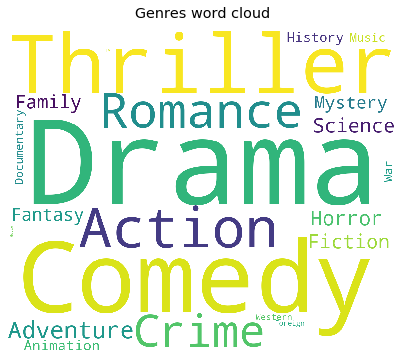

In [19]:
### first, let's look for the movie genres and how they affect the data:
list_of_genres = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

plt.figure(figsize = (10, 6))
text = ' '.join([i for j in list_of_genres for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Genres word cloud', pad=12)
plt.axis("off")
plt.show()


In [13]:
### get the unique genres


In [47]:
def add_genres_features(df, list_of_genres):
    '''Adds the num_genres and ont hot encoding of genres'''
    genres_unique = set(x for l in list_of_genres for x in l)
    df['num_genres'] = df['genres'].apply(lambda x: len(x) if x != {} else 0)
    df['all_genres'] = df['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
    
    for genre in genres_unique:
        df[genre] = df['all_genres'].apply(lambda x: 1 if genre in x else 0)
    
    #train = train.drop(['genres', 'all_genres'], axis=1)
    return df

train = add_genres_features(train, list_of_genres)

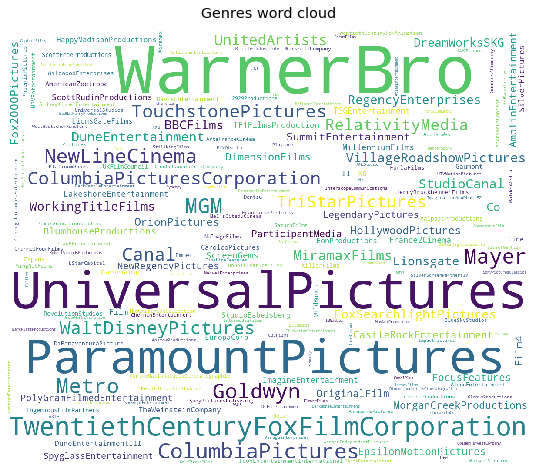

In [55]:
### investigating production companies
list_of_companies = list(train['production_companies'].apply(lambda x: [i['name'].replace(' ', '') for i in x] if x != {} else []).values)


plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_companies for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Genres word cloud', pad=12)
plt.axis("off")
plt.show()

In [39]:
top_companies = [list(m) for m in Counter([i for j in list_of_companies for i in j]).most_common(10)]
top_companies = pd.DataFrame(data=top_companies, columns=['Production Company', 'Number of Productions'])

In [42]:
top_companies.head()

,Production Company,Number of Productions
0,WarnerBros.,202
1,UniversalPictures,188
2,ParamountPictures,161
3,TwentiethCenturyFoxFilmCorporation,138
4,ColumbiaPictures,91


Text(0.5, 1.0, 'Top 10 production companies')

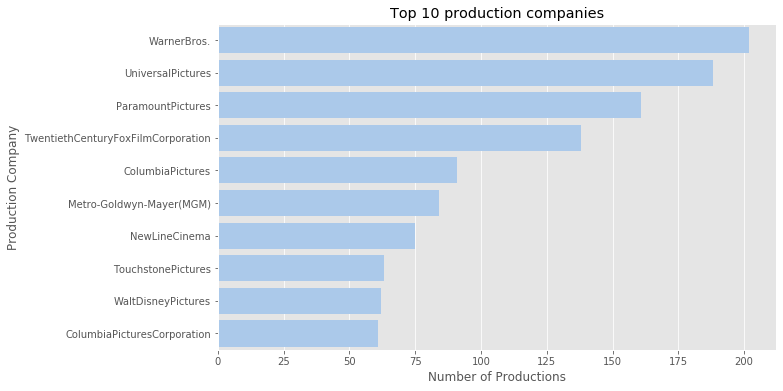

In [46]:
plt.figure(figsize = (10, 6))
sns.set_color_codes("pastel")
sns.barplot(x="Number of Productions", y="Production Company", data=top_companies,
             color="b")
plt.title('Top 10 production companies')

In [53]:
def add_production_companies_features(df, top_production_companies):
    df['num_companies'] = df['production_companies'].apply(lambda x: len(x) if x != {} else 0)
    df['all_companies'] = df['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
    for company in top_production_companies:
        df[ 'is_by_'+company] = df['all_companies'].apply(lambda x: 1 if company in x else 0)
    
    return df

train = add_production_companies_features(train, top_companies['Production Company'] )

In [51]:
[ company[0] for company in top_companies]
train = train.drop(['is_by_P', 'is_by_N'], axis=1)

In [54]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,num_genres,all_genres,Animation,Comedy,Science Fiction,Fantasy,Action,Family,Foreign,Adventure,History,Drama,TV Movie,War,Western,Music,Thriller,Romance,Crime,Mystery,Documentary,Horror,num_companies,all_companies,is_by_WarnerBros.,is_by_UniversalPictures,is_by_ParamountPictures,is_by_TwentiethCenturyFoxFilmCorporation,is_by_ColumbiaPictures,is_by_Metro-Goldwyn-Mayer(MGM),is_by_NewLineCinema,is_by_TouchstonePictures,is_by_WaltDisneyPictures,is_by_ColumbiaPicturesCorporation
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,1,Comedy,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,Metro-Goldwyn-Mayer (MGM) Paramount Pictures U...,0,0,0,0,0,0,0,0,0,0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,4,Comedy Drama Family Romance,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,Walt Disney Pictures,0,0,0,0,0,0,0,0,0,0
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,1,Drama,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,Blumhouse Productions Bold Films Right of Way ...,0,0,0,0,0,0,0,0,0,0
3,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,{},"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,2,Drama Thriller,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,,0,0,0,0,0,0,0,0,0,0
4,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,{},"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,{},"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923

In [57]:
### Check Movie Series effect
train['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0).value_counts() ## we have 2396 movie without series, and 604 series related

0    2396
1     604
Name: belongs_to_collection, dtype: int64

In [60]:
### add this measure
def add_series_collection_features(df):
    
    df['is_part_of_series_collection'] = df['belongs_to_collection'].apply(lambda x: len(x) if x != {} else 0)
    return df

train = add_series_collection_features(train)

C:\Users\ahelh\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'distribution of revenue per language')

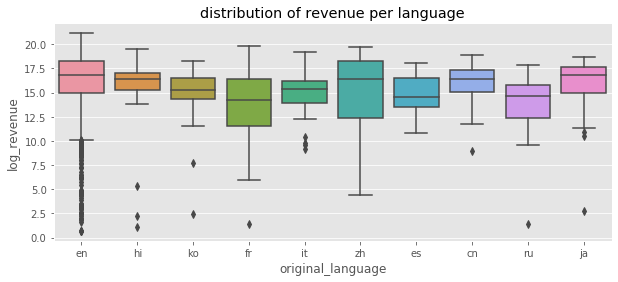

In [64]:
### investigating the language:
language_data = train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]
language_data['log_revenue'] = np.log1p(language_data['revenue'])
### plot mean of revenue per language
plt.figure(figsize=(10,4))
sns.boxplot(x='original_language', y='log_revenue', data=language_data)
plt.title('distribution of revenue per language')

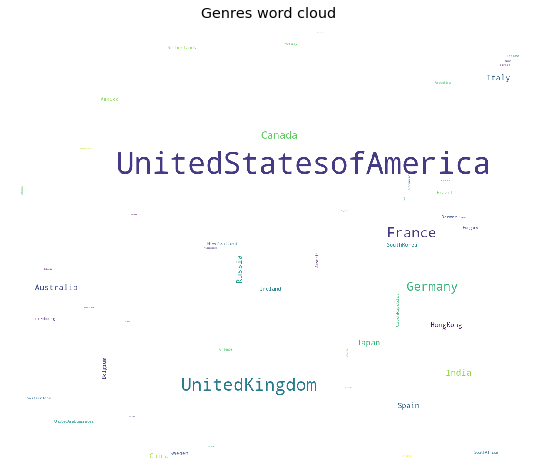

In [66]:
### investigating production countries
list_of_production_countries = list(train['production_countries'].apply(lambda x: [i['name'].replace(' ', '') for i in x] if x != {} else []).values)


plt.figure(figsize = (12, 8))
text = ' '.join([i for j in list_of_production_countries for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Genres word cloud', pad=12)
plt.axis("off")
plt.show()

In [69]:
top_countries = [list(m) for m in Counter([i for j in list_of_production_countries for i in j]).most_common(10)]
top_countries = pd.DataFrame(data=top_countries, columns=['Production Country', 'Number of Productions'])

Text(0.5, 1.0, 'Top 10 production countries')

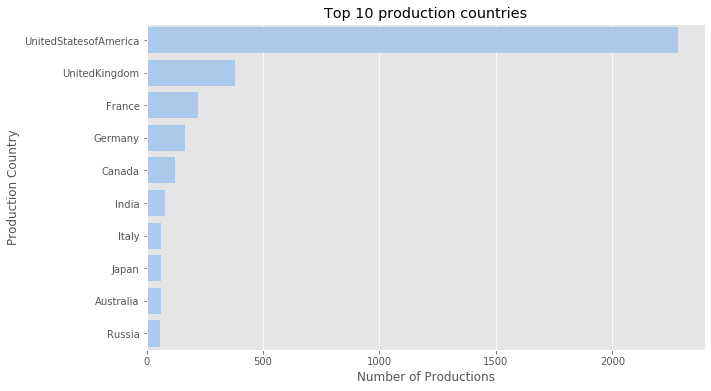

In [70]:
plt.figure(figsize = (10, 6))
sns.set_color_codes("pastel")
sns.barplot(x="Number of Productions", y="Production Country", data=top_countries,
             color="b")
plt.title('Top 10 production countries')

In [73]:
def add_production_countries_features(df, top_production_countries):
    df['num_countries'] = df['production_countries'].apply(lambda x: len(x) if x != {} else 0)
    df['all_countries'] = df['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
    for company in top_production_countries:
        df[ 'is_by_'+company] = df['all_countries'].apply(lambda x: 1 if company in x else 0)
    
    return df

In [74]:
train = add_production_countries_features(train, top_countries )